# A data mining task: classification + detection

## Step2: data exploration
Questa sezione esplora il dataset **Playing Cards Object Detection** (YOLO format) per capire:

- struttura delle cartelle e presenza di file mancanti

- distribuzione delle **classi** e dei **bounding box** (per split e globale)

- dimensioni delle immagini, rapporti d'aspetto, aree delle bbox

- esempi visuali (immagini + bbox)

- eventuali **anomalie** nelle etichette (valori fuori [0,1], bbox nulle, classi mancanti)



> **Nota**: questo notebook non richiede internet. Imposta `DATA_ROOT` al path del dataset scaricato da Kaggle.


### Setup

In [3]:
# Percorso radice del dataset (modifica qui)
DATA_ROOT = "./dataset"

# Dipendenze
import os, json, math, glob, yaml, random, statistics
from pathlib import Path
from collections import Counter, defaultdict
import numpy as np
import pandas as pd
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

# Matplotlib: no stile nè colori specifici (richiesta)
%matplotlib inline

# Utility
def yolo_to_xyxy(xc, yc, w, h, W, H):
    """Converti bbox YOLO normalizzata (xc,yc,w,h in [0,1]) a pixel (x1,y1,x2,y2)."""
    x1 = (xc - w/2) * W
    y1 = (yc - h/2) * H
    x2 = (xc + w/2) * W
    y2 = (yc + h/2) * H
    return max(0, x1), max(0, y1), min(W-1, x2), min(H-1, y2)

def load_classes_from_yaml(root):
    # Cerca un data.yaml tipico YOLO (train/val/test paths + names)
    candidates = list(Path(root).rglob("data.yaml"))
    if candidates:
        with open(candidates[0], "r") as f:
            data = yaml.safe_load(f)
        names = data.get("names")
        if isinstance(names, dict):
            # a volte è {0:'A',1:'B',...}
            max_k = max(int(k) for k in names.keys())
            arr = [names.get(i, names.get(str(i), f'class_{i}')) for i in range(max_k+1)]
            return arr
        if isinstance(names, list):
            return names
    # fallback: None
    return None

def find_splits(root):
    # Assumiamo struttura YOLO standard: split/{images,labels}
    root = Path(root)
    splits = {}
    for split in ["train","valid","val","test"]:
        img_dir = root / split / "images"
        lbl_dir = root / split / "labels"
        if img_dir.exists() and lbl_dir.exists():
            splits[split] = {"images": img_dir, "labels": lbl_dir}
    # In assenza di split, prova una singola cartella images/labels
    if not splits:
        img_dir = root / "images"
        lbl_dir = root / "labels"
        if img_dir.exists() and lbl_dir.exists():
            splits["all"] = {"images": img_dir, "labels": lbl_dir}
    return splits

def read_label_file(path):
    # Ogni riga: class xc yc w h  (tutti normalizzati)
    out = []
    with open(path, "r") as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) != 5 and len(parts) != 6: # len==6 gestisce formati con conf opzionale
                continue
            cls = int(float(parts[0]))
            xc, yc, w, h = map(float, parts[1:5])
            out.append((cls, xc, yc, w, h))
    return out


### 1) Struttura del dataset

In [4]:
splits = find_splits(DATA_ROOT)
classes = load_classes_from_yaml(DATA_ROOT)

print("Split trovati:")
for s, d in splits.items():
    print(f"- {s}: images={d['images']}, labels={d['labels']}")

if classes is not None:
    print(f"\nClassi rilevate da data.yaml: {len(classes)} classi")
    for i, name in enumerate(classes):
        print(f"  {i}: {name}")
else:
    print("\nNessun file data.yaml trovato, le classi saranno mostrate come id numerici.")

Split trovati:
- train: images=dataset/train/images, labels=dataset/train/labels
- valid: images=dataset/valid/images, labels=dataset/valid/labels
- test: images=dataset/test/images, labels=dataset/test/labels

Classi rilevate da data.yaml: 52 classi
  0: 10c
  1: 10d
  2: 10h
  3: 10s
  4: 2c
  5: 2d
  6: 2h
  7: 2s
  8: 3c
  9: 3d
  10: 3h
  11: 3s
  12: 4c
  13: 4d
  14: 4h
  15: 4s
  16: 5c
  17: 5d
  18: 5h
  19: 5s
  20: 6c
  21: 6d
  22: 6h
  23: 6s
  24: 7c
  25: 7d
  26: 7h
  27: 7s
  28: 8c
  29: 8d
  30: 8h
  31: 8s
  32: 9c
  33: 9d
  34: 9h
  35: 9s
  36: Ac
  37: Ad
  38: Ah
  39: As
  40: Jc
  41: Jd
  42: Jh
  43: Js
  44: Kc
  45: Kd
  46: Kh
  47: Ks
  48: Qc
  49: Qd
  50: Qh
  51: Qs


### 2) Indicizzazione immagini e annotazioni

In [5]:
rows = []
for split, d in splits.items():
    img_paths = sorted(glob.glob(str(d['images'] / "*")))
    lbl_paths = {Path(p).stem: p for p in glob.glob(str(d['labels'] / "*.txt"))}
    for ip in img_paths:
        stem = Path(ip).stem
        lp = lbl_paths.get(stem, None)
        rows.append({"split": split, "image_path": ip, "label_path": lp})

df = pd.DataFrame(rows)
print(df.head())
print("\nConteggio immagini per split:\n", df.groupby("split").size())

# percentuale immagini senza label
missing = df['label_path'].isna().mean()*100
print(f"\n% immagini senza etichette: {missing:.2f}%")

   split                                         image_path  \
0  train  dataset/train/images/000090528_jpg.rf.d50e8961...   
1  train  dataset/train/images/000233645_jpg.rf.843259f9...   
2  train  dataset/train/images/000452673_jpg.rf.691b3960...   
3  train  dataset/train/images/000554394_jpg.rf.8be18f32...   
4  train  dataset/train/images/000609988_jpg.rf.53fdbac0...   

                                          label_path  
0  dataset/train/labels/000090528_jpg.rf.d50e8961...  
1  dataset/train/labels/000233645_jpg.rf.843259f9...  
2  dataset/train/labels/000452673_jpg.rf.691b3960...  
3  dataset/train/labels/000554394_jpg.rf.8be18f32...  
4  dataset/train/labels/000609988_jpg.rf.53fdbac0...  

Conteggio immagini per split:
 split
test      2000
train    14000
valid     4000
dtype: int64

% immagini senza etichette: 0.00%


### 3) Dimensioni immagini

         width   height   aspect
count  20000.0  20000.0  20000.0
mean     416.0    416.0      1.0
std        0.0      0.0      0.0
min      416.0    416.0      1.0
25%      416.0    416.0      1.0
50%      416.0    416.0      1.0
75%      416.0    416.0      1.0
max      416.0    416.0      1.0


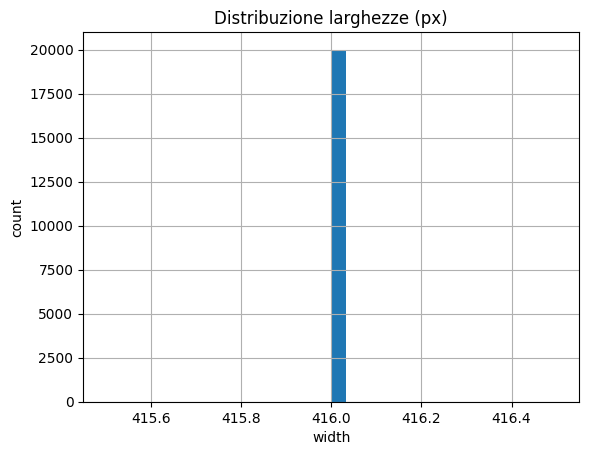

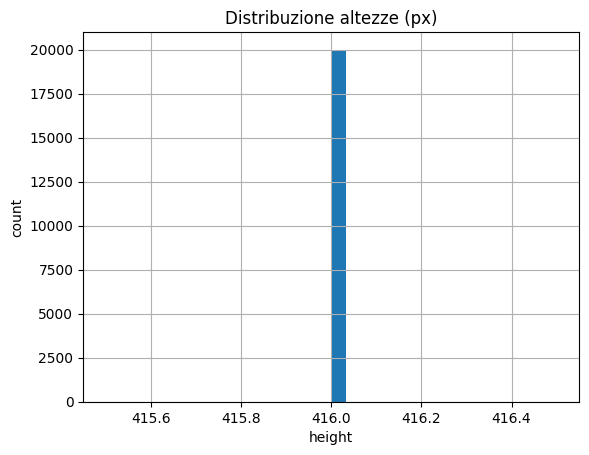

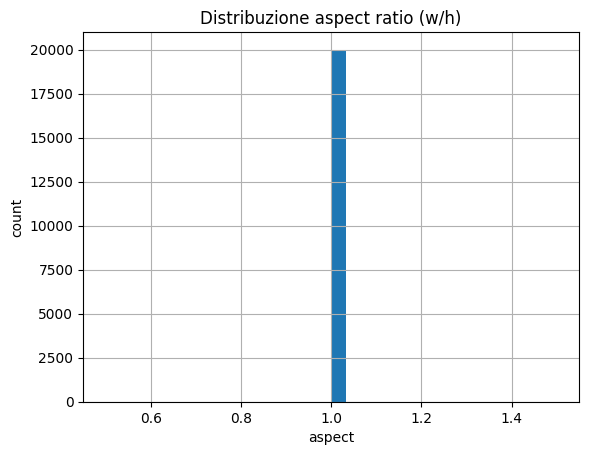

In [6]:
def get_img_size(p):
    try:
        with Image.open(p) as im:
            return im.width, im.height
    except Exception:
        return None, None

sizes = df['image_path'].apply(get_img_size)
df['width'] = [w for w,h in sizes]
df['height'] = [h for w,h in sizes]
df['aspect'] = df['width'] / df['height']

print(df[['split','width','height','aspect']].describe())

# Istogrammi (uno per volta, niente subplot né colori custom)
plt.figure()
df['width'].dropna().hist(bins=30)
plt.title('Distribuzione larghezze (px)')
plt.xlabel('width')
plt.ylabel('count')
plt.show()

plt.figure()
df['height'].dropna().hist(bins=30)
plt.title('Distribuzione altezze (px)')
plt.xlabel('height')
plt.ylabel('count')
plt.show()

plt.figure()
df['aspect'].dropna().hist(bins=30)
plt.title('Distribuzione aspect ratio (w/h)')
plt.xlabel('aspect')
plt.ylabel('count')
plt.show()

### 4) Lettura etichette YOLO e statistiche bbox

   split                                         image_path  class_id  \
0  train  dataset/train/images/000090528_jpg.rf.d50e8961...        51   
1  train  dataset/train/images/000090528_jpg.rf.d50e8961...        37   
2  train  dataset/train/images/000090528_jpg.rf.d50e8961...        37   
3  train  dataset/train/images/000233645_jpg.rf.843259f9...        17   
4  train  dataset/train/images/000233645_jpg.rf.843259f9...        24   

         xc        yc         w         h      area    aspect  img_w  img_h  
0  0.460337  0.693510  0.064904  0.042067  0.002730  1.542857    416    416  
1  0.644231  0.501202  0.063702  0.088942  0.005666  0.716216    416    416  
2  0.614183  0.074519  0.064904  0.088942  0.005773  0.729730    416    416  
3  0.480769  0.793269  0.063702  0.055288  0.003522  1.152174    416    416  
4  0.445913  0.737981  0.066106  0.052885  0.003496  1.250000    416    416  

Totale bbox: 75750
Bbox con normalizzazione fuori [0,1]: 0
Bbox con area nulla (w==0 o h==0)

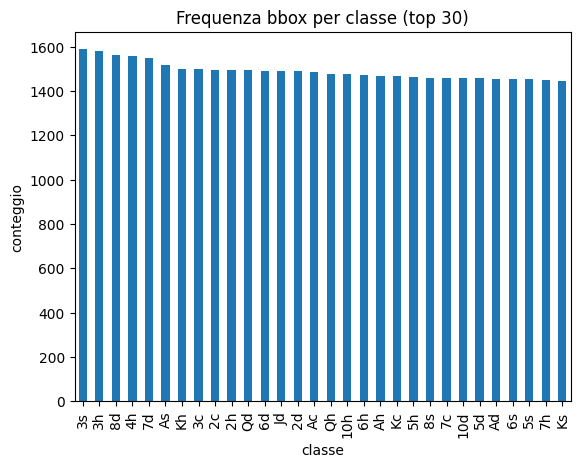

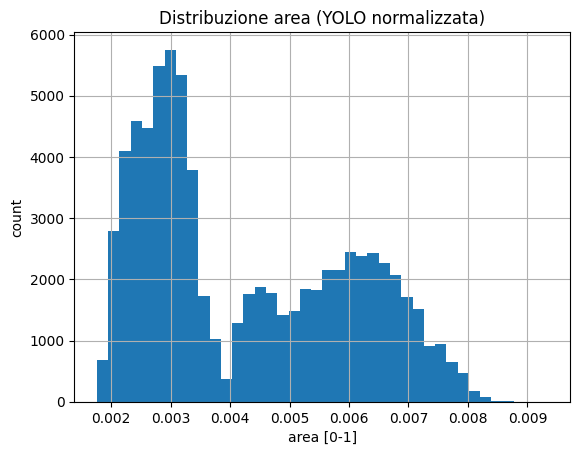

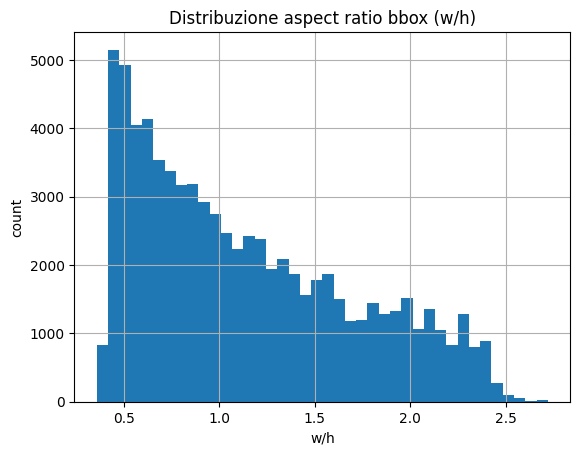

In [7]:
label_rows = []
bad_norm = 0
zero_area = 0

for idx, r in df.dropna(subset=['label_path']).iterrows():
    W, H = int(r['width'] or 0), int(r['height'] or 0)
    try:
        items = read_label_file(r['label_path'])
    except Exception:
        items = []
    for (cls, xc, yc, w, h) in items:
        # controlli di validità
        if not (0 <= xc <= 1 and 0 <= yc <= 1 and 0 <= w <= 1 and 0 <= h <= 1):
            bad_norm += 1
        if w <= 0 or h <= 0:
            zero_area += 1
        area = w * h
        aspect = (w / h) if h > 0 else None
        label_rows.append({
            "split": r['split'],
            "image_path": r['image_path'],
            "class_id": cls,
            "xc": xc, "yc": yc, "w": w, "h": h,
            "area": area, "aspect": aspect,
            "img_w": W, "img_h": H
        })

labels_df = pd.DataFrame(label_rows)
print(labels_df.head())
print("\nTotale bbox:", len(labels_df))
print("Bbox con normalizzazione fuori [0,1]:", bad_norm)
print("Bbox con area nulla (w==0 o h==0):", zero_area)

# Distribuzione classi (globale e per split)
print("\nDistribuzione classi globale (prime 20):\n", labels_df['class_id'].value_counts().head(20))
print("\nDistribuzione per split:\n", labels_df.groupby(['split','class_id']).size().unstack(fill_value=0).head())

# Mappa id -> nome
if classes is not None:
    labels_df['class_name'] = labels_df['class_id'].apply(lambda i: classes[i] if i < len(classes) else f'class_{i}')
else:
    labels_df['class_name'] = labels_df['class_id'].apply(lambda i: f'class_{i}')

# Grafico frequenze per classi (top 30)
cnt = labels_df['class_name'].value_counts().sort_values(ascending=False).head(30)
plt.figure()
cnt.plot(kind='bar')
plt.title('Frequenza bbox per classe (top 30)')
plt.xlabel('classe')
plt.ylabel('conteggio')
plt.xticks(rotation=90)
plt.show()

# Distribuzione aree bbox
plt.figure()
labels_df['area'].dropna().hist(bins=40)
plt.title('Distribuzione area (YOLO normalizzata)')
plt.xlabel('area [0-1]')
plt.ylabel('count')
plt.show()

# Distribuzione aspect ratio bbox
plt.figure()
labels_df['aspect'].dropna().hist(bins=40)
plt.title('Distribuzione aspect ratio bbox (w/h)')
plt.xlabel('w/h')
plt.ylabel('count')
plt.show()

### 5) Visualizzazione esempi con bounding box

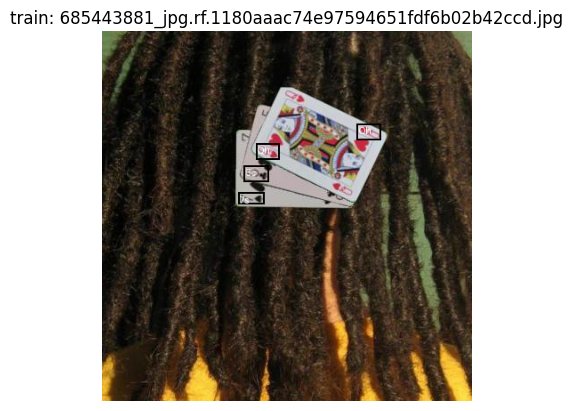

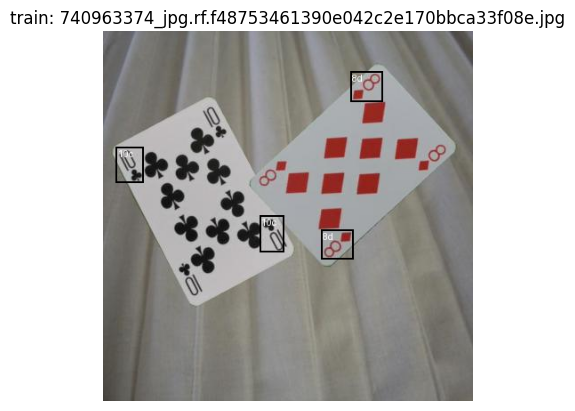

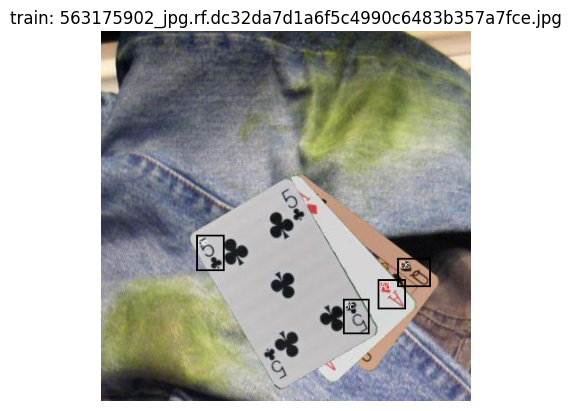

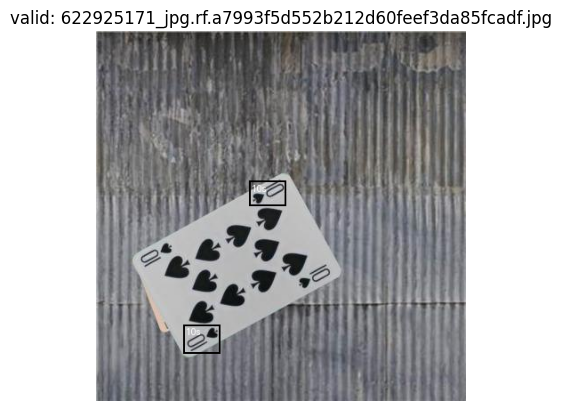

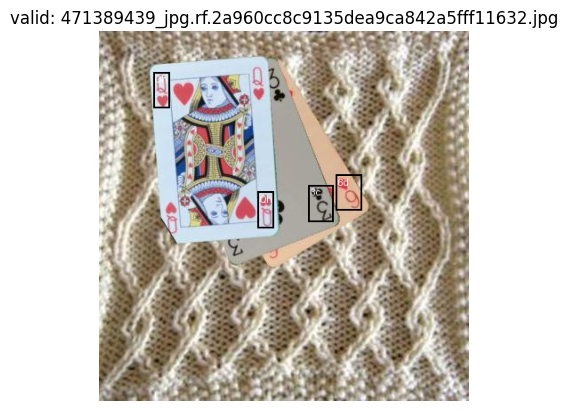

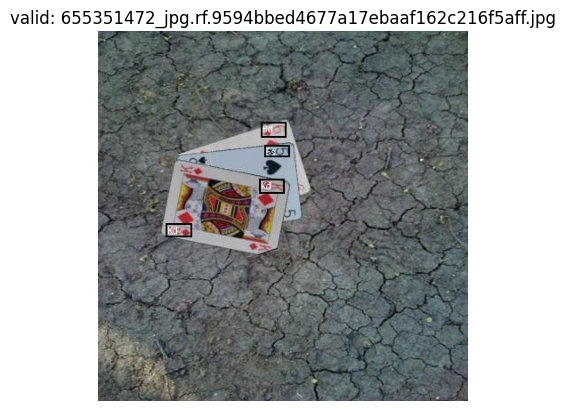

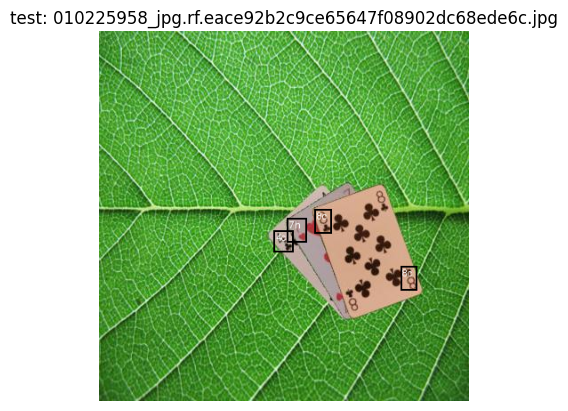

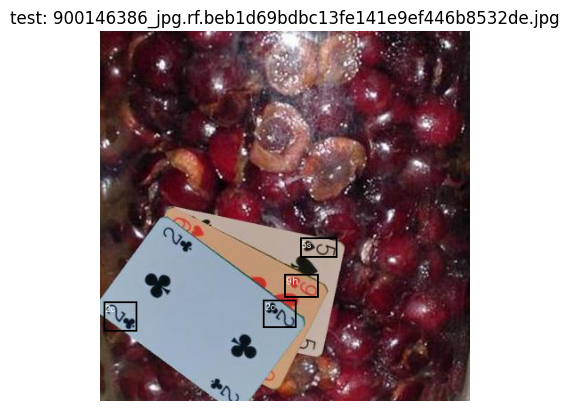

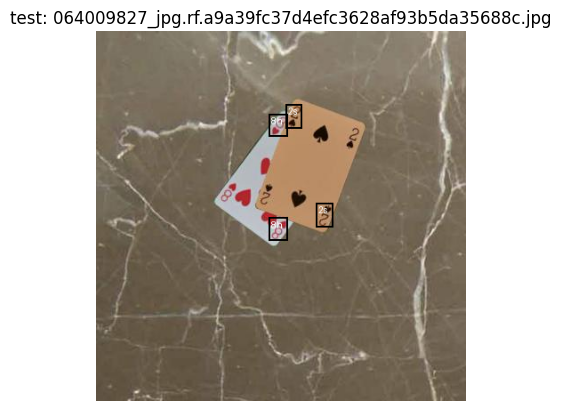

In [8]:
def draw_yolo_boxes(image_path, label_path, class_names=None, max_boxes=50):
    im = Image.open(image_path).convert("RGB")
    W, H = im.size
    draw = ImageDraw.Draw(im)
    if label_path and os.path.exists(label_path):
        items = read_label_file(label_path)[:max_boxes]
        for (cls, xc, yc, w, h) in items:
            x1, y1, x2, y2 = yolo_to_xyxy(xc, yc, w, h, W, H)
            # rettangolo + testo
            draw.rectangle([x1, y1, x2, y2], outline=1, width=2)
            label = str(cls) if class_names is None else f"{class_names[cls] if cls < len(class_names) else cls}"
            draw.text((x1+2, y1+2), label)
    return im

# Visualizza 3 esempi a caso per split
random.seed(0)
for split in splits.keys():
    subset = df[(df['split']==split) & (~df['label_path'].isna())]
    sample = subset.sample(min(3, len(subset))) if len(subset) else pd.DataFrame()
    for _, row in sample.iterrows():
        im = draw_yolo_boxes(row['image_path'], row['label_path'], classes)
        plt.figure()
        plt.imshow(im)
        plt.axis('off')
        plt.title(f'{split}: {Path(row["image_path"]).name}')
        plt.show()

### 6) Statistiche per immagine

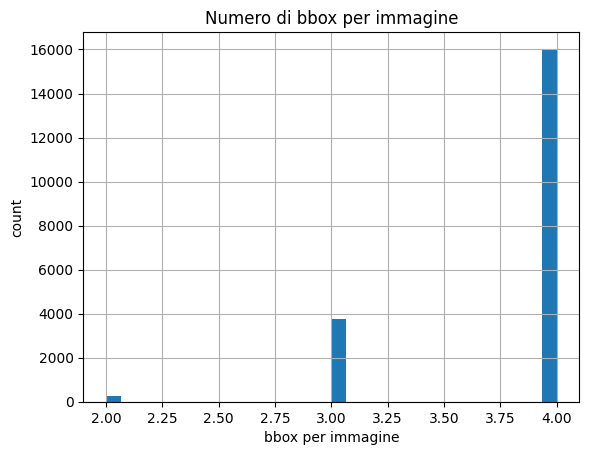

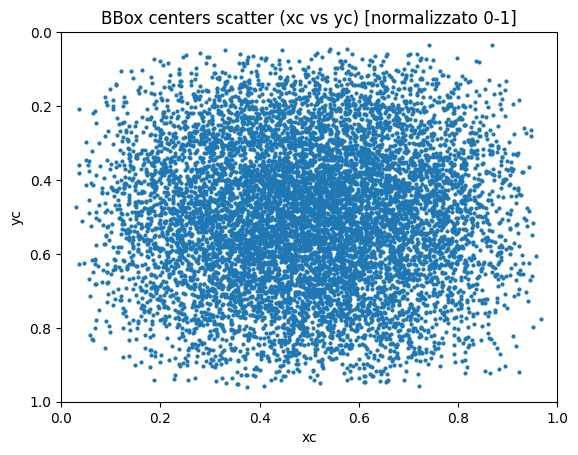

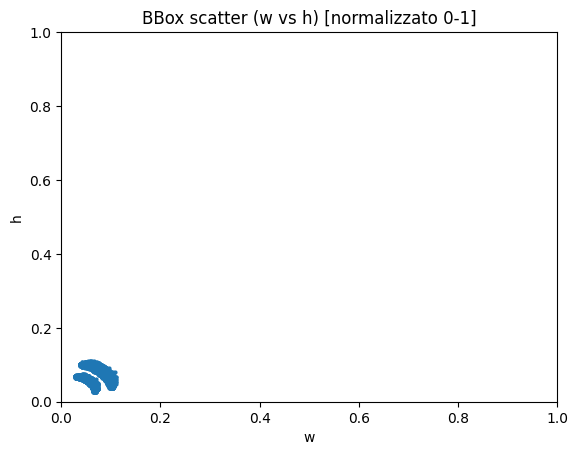

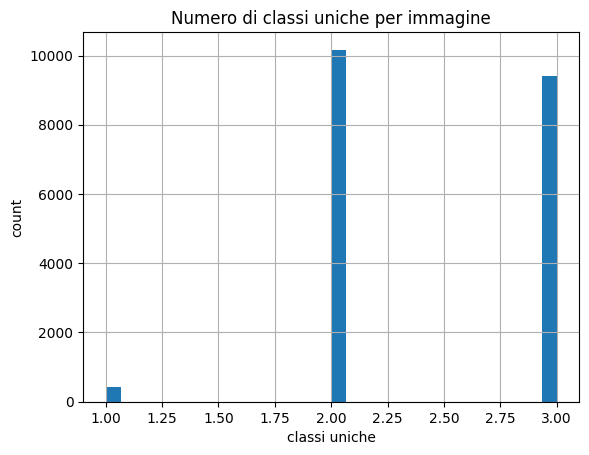

In [11]:
# bbox per immagine
bbox_per_image = labels_df.groupby('image_path').size()
plt.figure()
bbox_per_image.hist(bins=30)
plt.title('Numero di bbox per immagine')
plt.xlabel('bbox per immagine')
plt.ylabel('count')
plt.show()

# Scatter dei centri bbox normalizzati (xc, yc)
if len(labels_df) > 0:
    n = min(10000, len(labels_df))
    sample_centers = labels_df.sample(n, random_state=0)[["xc", "yc"]].dropna()
    plt.figure()
    plt.scatter(sample_centers["xc"], sample_centers["yc"], s=4)
    plt.title("BBox centers scatter (xc vs yc) [normalizzato 0-1]")
    plt.xlabel("xc")
    plt.ylabel("yc")
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.gca().invert_yaxis()  # opzionale: origine in alto come coordinate immagine
    plt.show()
else:
    print("labels_df è vuoto: nessuna bbox da visualizzare.")

# Scatter w vs h delle bbox (YOLO normalizzato)
if len(labels_df) > 0:
    bb = labels_df[["w", "h"]].dropna()
    n = min(20000, len(bb))
    bb = bb.sample(n, random_state=0)
    plt.figure()
    plt.scatter(bb["w"], bb["h"], s=4)
    plt.title("BBox scatter (w vs h) [normalizzato 0-1]")
    plt.xlabel("w")
    plt.ylabel("h")
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.show()
else:
    print("labels_df è vuoto: nessuna bbox da visualizzare.")


# classi uniche per immagine
classes_per_image = labels_df.groupby('image_path')['class_id'].nunique()
plt.figure()
classes_per_image.hist(bins=30)
plt.title('Numero di classi uniche per immagine')
plt.xlabel('classi uniche')
plt.ylabel('count')
plt.show()

### 7) Sanity check su etichette

In [10]:
# bbox che escono dai limiti
out_of_bounds = labels_df.query('xc<0 or xc>1 or yc<0 or yc>1 or w<0 or w>1 or h<0 or h>1').shape[0]
print("Bbox con valori fuori [0,1]:", out_of_bounds)

# bbox troppo piccole o troppo grandi
too_small = labels_df.query('w*h < 1e-5').shape[0]
too_big = labels_df.query('w>0.9 or h>0.9').shape[0]
print("Bbox troppo piccole:", too_small)
print("Bbox molto grandi (w>0.9 or h>0.9):", too_big)

# immagini senza label (già calcolate)
missing_pct = df['label_path'].isna().mean()*100
print(f"Immagini senza label: {missing_pct:.2f}%")

Bbox con valori fuori [0,1]: 0
Bbox troppo piccole: 0
Bbox molto grandi (w>0.9 or h>0.9): 0
Immagini senza label: 0.00%


### 8) Riassunto e takeaway

- **Distribuzione classi:** verificare sbilanciamenti e, se necessario, pianificare un **weighted sampling** o **data augmentation** mirata.

- **Dimensioni immagini:** uniformare (es. resize) se molto variabili; considerare il mantenimento del ratio.

- **Bbox:** controllare outliers (aree troppo piccole/grandi) che possono influenzare il training.

- **Qualità etichette:** correggere eventuali valori fuori range o bbox nulle.

- **Split:** assicurarsi che **train/val/test** siano coerenti e non sovrapposti.



> Questi insight guidano **Step 3 (preprocessing)** e la scelta del modello (es. YOLOv5/8) per **Step 4 (processing)**.
